In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import os

# MyoArmband Dataset

In [5]:
train_path = 'datasets/MyoArmbandDataset/PreTrainingDataset/'
train_candidates = 12
eval_path = 'datasets/MyoArmbandDataset/EvaluationDataset/'
eval_candidates = 15

In [54]:
def get_raw_dataset(eval_path):
    person_folders = os.listdir(eval_path)

    first_folder = os.listdir(eval_path)[0]
    keys = next(os.walk((eval_path+first_folder)))[1]

    number_of_classes = 7
    number_of_vector_per_example = 52
    size_non_overlap = 5

    raw_dataset_dict = {}
    for key in keys:
            
        raw_dataset = {
            'examples': [],
            'labels': [],
        }
        list_dataset = []
        list_labels = []
        for person_dir in person_folders:
            examples = []
            labels = []
            data_path = eval_path + person_dir + '/' + key
            for data_file in os.listdir(data_path):
                if (data_file.endswith(".dat")):
                    data_read_from_file = np.fromfile((data_path+'/'+data_file), dtype=np.int16)
                    data_read_from_file = np.array(data_read_from_file, dtype=np.float32)

                    dataset_example_formatted = []
                    example = []
                    emg_vector = []
                    for value in data_read_from_file:
                        emg_vector.append(value)
                        if (len(emg_vector) >= 8):
                            if (example == []):
                                example = emg_vector
                            else:
                                example = np.row_stack((example, emg_vector))
                            emg_vector = []
                            if (len(example) >= number_of_vector_per_example):
                                example = example.transpose()
                                dataset_example_formatted.append(example)
                                example = example.transpose()
                                example = example[size_non_overlap:]
                    dataset_example_formatted = np.array(dataset_example_formatted)
                    examples.append(dataset_example_formatted)
                    data_file_index = int(data_file.split('classe_')[1][:-4])
                    label = data_file_index % number_of_classes + np.zeros(dataset_example_formatted.shape[0])
                    labels.append(label)

            raw_dataset['examples'].append(np.concatenate(examples))
            raw_dataset['labels'].append(np.concatenate(labels))

        raw_dataset_dict[key] = raw_dataset

    return raw_dataset_dict

In [59]:
eval_raw_dataset_dict = get_raw_dataset(eval_path)

/var/folders/k8/_qw1v4gj2cv9cqh75_yrt3pc0000gn/T/ipykernel_31040/3666496798.py:35: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (example == []):


In [60]:
train_raw_dataset_dict = get_raw_dataset(train_path)

/var/folders/k8/_qw1v4gj2cv9cqh75_yrt3pc0000gn/T/ipykernel_31040/3666496798.py:35: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (example == []):


In [62]:
len(train_raw_dataset_dict['training0']['examples'])

22

In [64]:
len(eval_raw_dataset_dict['training0']['examples'])

40

In [9]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomEMGDataset(Dataset):
    def __init__(self, x_samples, y_samples):
        self.x_samples = x_samples
        self.y_samples = y_samples

    def __len__(self):
        return len(self.x_samples)
    
    def __getitem__(self, idx):
        x_tensor = torch.tensor(self.x_samples[idx,:,:])
        y_tensor = torch.tensor(self.y_samples[idx]).type(torch.LongTensor)
        return x_tensor, y_tensor

In [ ]:
# single person
train_x = raw_dataset_dict['training0']['examples'][0]
train_y = raw_dataset_dict['training0']['labels'][0]
test_x = raw_dataset_dict['Test0']['examples'][0]
test_y = raw_dataset_dict['Test0']['labels'][0]

In [83]:
# all people
train_x = np.concatenate(eval_raw_dataset_dict['training0']['examples'])
train_y = np.concatenate(raw_dataset_dict['training0']['labels'])
test_x = np.concatenate(raw_dataset_dict['Test0']['examples'])
test_y = np.concatenate(raw_dataset_dict['Test0']['labels'])

In [66]:
# all people
train_x = np.concatenate(eval_raw_dataset_dict['training0']['examples']+train_raw_dataset_dict['training0']['examples'])
train_y = np.concatenate(raw_dataset_dict['training0']['labels']+train_raw_dataset_dict['training0']['labels'])
test_x = np.concatenate(raw_dataset_dict['Test0']['examples'])
test_y = np.concatenate(raw_dataset_dict['Test0']['labels'])

In [ ]:
# TODO filter only labels we need


In [84]:
train_dataset = CustomEMGDataset(train_x, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomEMGDataset(train_x, train_y)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [85]:
x, y = next(iter(test_dataloader))

<AxesSubplot:>

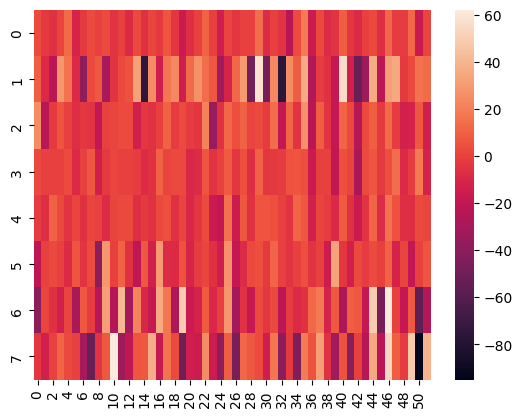

In [86]:
sns.heatmap(x[0,:,:])

In [17]:
import torch
import torch.nn as nn

In [101]:
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.flatten = nn.Flatten(start_dim=1)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out

In [102]:
train_features, train_labels = next(iter(train_dataloader))

In [144]:
model = FFNN(52*8, 128, number_of_classes)

In [145]:
model(train_features).shape

torch.Size([32, 7])

In [77]:
device = 'mps'

In [87]:
import torch
from vit_pytorch import ViT

model = ViT(
    image_size = 52,
    patch_size = 4,
    num_classes = 7,
    dim = 64,
    depth = 2,
    heads = 4,
    mlp_dim = 128,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels=1,
).to(device) 

img = torch.randn(10, 1, 8, 52).to(device)

preds = model(img)

In [88]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [89]:
history = {
    'accs': [],
    'losses': [],
}

for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        if model.__class__.__name__ == 'ViT':
            inputs.unsqueeze_(axis=1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        history['losses'].append(loss.item())
        if i % 1000 == 999:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.8f}')
            running_loss = 0.0

    accs = []
    for data in test_dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if model.__class__.__name__ == 'ViT':
            inputs.unsqueeze_(axis=1)
        model.eval()
        with torch.no_grad():
            outputs = model(inputs)
            predicted_labels = outputs.cpu().max(dim=1).indices

        labels = labels.cpu()
        acc = accuracy_score(labels, predicted_labels)
        accs.append(acc)

    history['accs'].append( np.mean(accs))
    print('test accuracy', np.mean(accs))

print('Finished Training')

[1,  1000] loss: 1.17916353
[1,  2000] loss: 0.80160099
test accuracy 0.8225403028508151
[2,  1000] loss: 0.55719111
[2,  2000] loss: 0.49366789
test accuracy 0.8819741314928793
[3,  1000] loss: 0.39584781
[3,  2000] loss: 0.36914397
test accuracy 0.9102078558368314
[4,  1000] loss: 0.32570548
[4,  2000] loss: 0.30741461
test accuracy 0.9089210295897607
[5,  1000] loss: 0.27376763
[5,  2000] loss: 0.28317430
test accuracy 0.9506901702248204
[6,  1000] loss: 0.26098932
[6,  2000] loss: 0.25520269
test accuracy 0.9497695140480544
[7,  1000] loss: 0.24262830
[7,  2000] loss: 0.23783706
test accuracy 0.9494580682959491
[8,  1000] loss: 0.22684495
[8,  2000] loss: 0.23421521
test accuracy 0.9600745860266282
[9,  1000] loss: 0.21550799
[9,  2000] loss: 0.21792765
test accuracy 0.9619706226983595
[10,  1000] loss: 0.20717899
[10,  2000] loss: 0.20560316
test accuracy 0.9624204887847339
[11,  1000] loss: 0.19757751
[11,  2000] loss: 0.20066606
test accuracy 0.966882935026139
[12,  1000] loss: 

KeyboardInterrupt: 

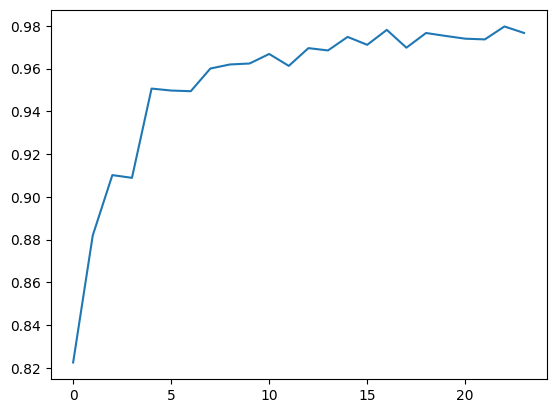

In [90]:
plt.plot(history['accs'])

In [ ]:
plt.plot(history['losses'])

In [92]:
import time

In [91]:
single_test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [94]:
dts = []
for data in single_test_dataloader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    if model.__class__.__name__ == 'ViT':
        inputs.unsqueeze_(axis=1)
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        outputs = model(inputs)
        predicted_labels = outputs.cpu().max(dim=1).indices

    dt = time.time() - start_time
    dts.append(dt)
    # print('dt', dt)

In [101]:
torch.save(model, 'pretained_vit.pt')

In [102]:
model_state_dict = model.state_dict()
torch.save(model_state_dict, 'pretained_vit_state_dict.pt')

In [96]:
dts = np.array(dts)
dts[0]

0.0048601627349853516

In [105]:
1 / dts[1:].mean(), 'Hz'

(333.90465095197, 'Hz')

# Transfer learning

**TODO**
Try if this improves performance

In [23]:
import copy
from pprint import pprint

import torch

# Models
# Encoder
G = torch.nn.Linear(1000, 100)
# CLassification head
C = torch.nn.Linear(100, 10)

D = torch.nn.Sequential(torch.nn.Linear(100, 1), torch.nn.Flatten(start_dim=0))
G_opt = torch.optim.Adam(G.parameters())
C_opt = torch.optim.Adam(C.parameters())
D_opt = torch.optim.Adam(D.parameters())

dataset_size = 10000
# 1 batch of data
example_data = {
    "src_imgs": torch.randn(32, 1000),
    "target_imgs": torch.randn(32, 1000),
    "src_labels": torch.randint(0, 10, size=(32,)),
    "src_domain": torch.zeros(32),
    "target_domain": torch.zeros(32),
    "src_sample_idx": torch.randint(0, dataset_size, size=(32,)),
    "target_sample_idx": torch.randint(0, dataset_size, size=(32,)),
}


def get_data(keys):
    return {k: example_data[k] for k in keys}

In [24]:
from pytorch_adapt.hooks import MCDHook
from pytorch_adapt.layers import MultipleModels, SlicedWasserstein
from pytorch_adapt.utils import common_functions as c_f

In [50]:
# MCD needs 2 classifiers
C_ = MultipleModels(C, c_f.reinit(copy.deepcopy(C)))
C_opt_ = torch.optim.Adam(C_.parameters())
loss_fn = SlicedWasserstein(m=128)

hook = MCDHook(g_opts=[G_opt], c_opts=[C_opt_], discrepancy_loss_fn=loss_fn)

models = {"G": G, "C": C_}
data = get_data(["src_imgs", "target_imgs", "src_labels"])
_, losses = hook({**models, **data})
pprint(losses)

{'x_loss': {'src_c_loss0': 0.006591843441128731,
            'src_c_loss1': 2.502946615219116,
            'total': 1.254769206047058},
 'y_loss': {'discrepancy_loss': -0.4307219982147217,
            'src_c_loss0': 0.005981766618788242,
            'src_c_loss1': 2.2412302494049072,
            'total': 0.6054966449737549},
 'z_loss': {'discrepancy_loss': 0.2203170657157898,
            'total': 0.2203170657157898}}
